In [ ]:
# pip install kagglehub[pandas-datasets]
# install the above by removing the hash symbol first to run this notebook

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import  make_column_selector as selector, ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif




In [9]:
file_path = "adult.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "mosapabdelghany/adult-income-prediction-dataset",
  file_path,
)
#df = pd.read_csv('/Users/E1012131/Downloads/adult.csv')
df.replace('?', np.nan, inplace=True)
df = df.dropna(how='all')  # Drop rows with missing values

print(df.describe())
print(df.columns)

100%|██████████| 3.91M/3.91M [00:02<00:00, 1.84MB/s]

                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.nu

In [10]:
X = df.drop(['income'], axis=1) # Features
y = df['income'].str.strip()  # trim

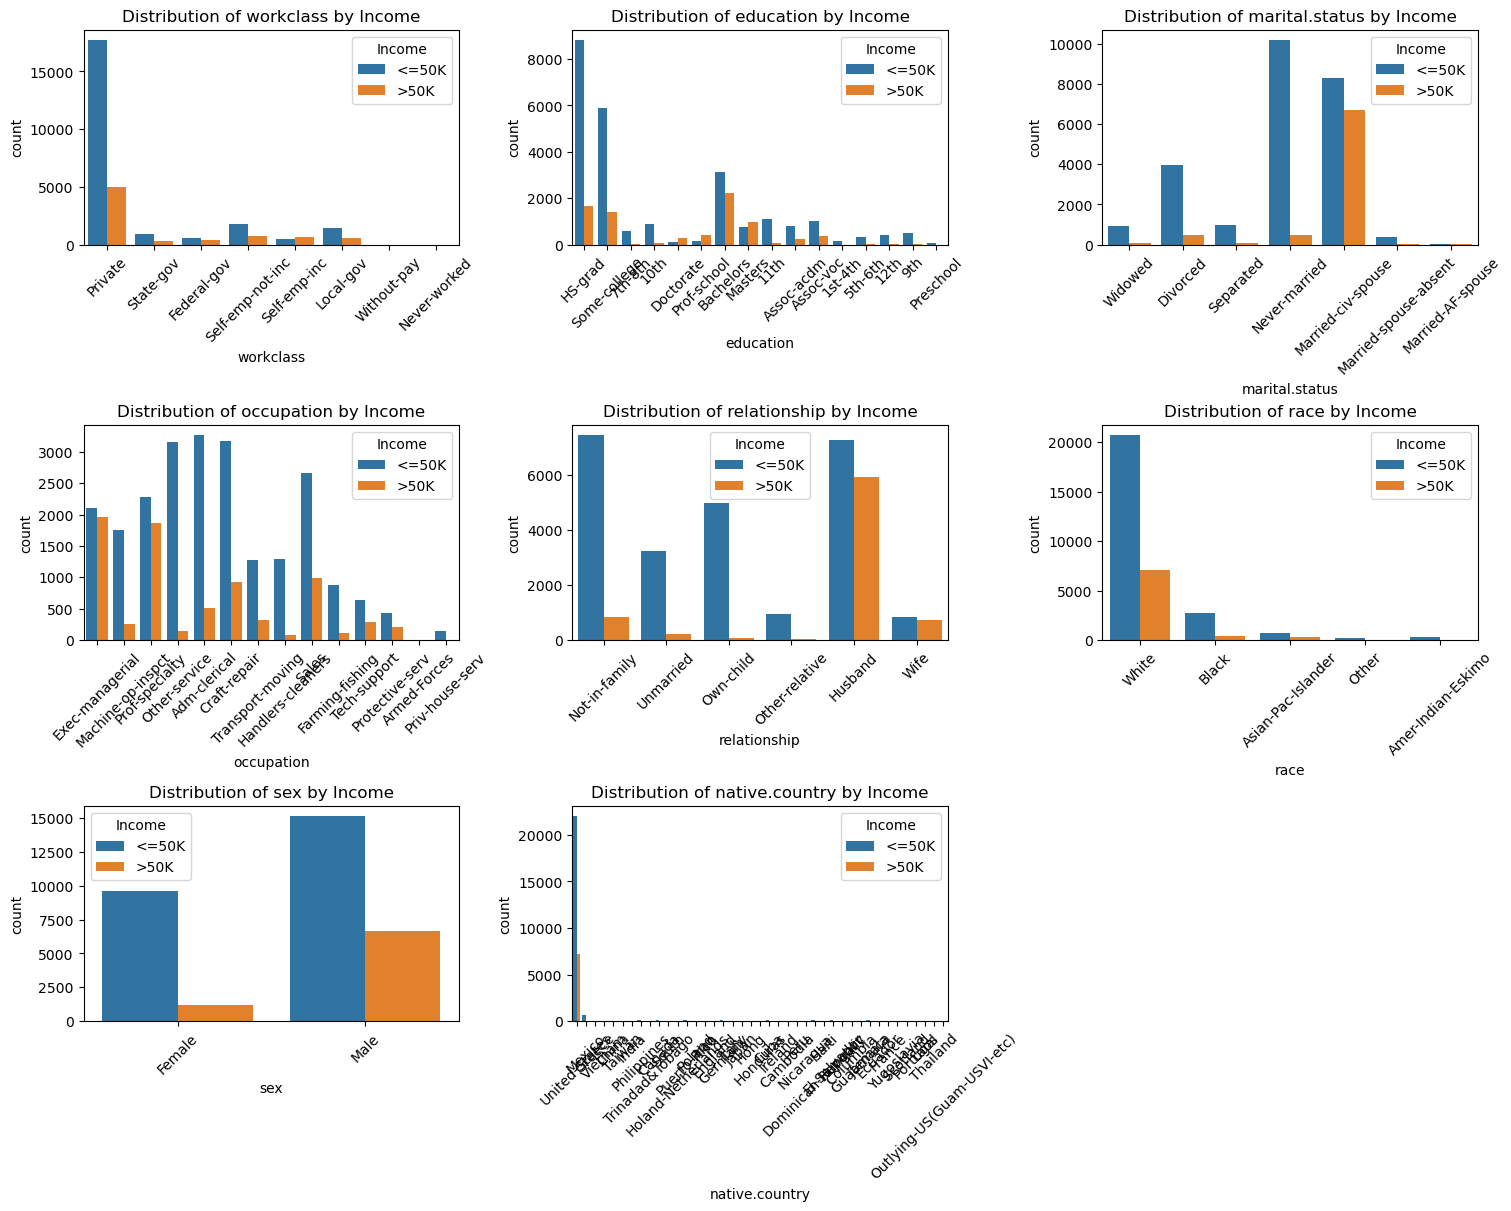

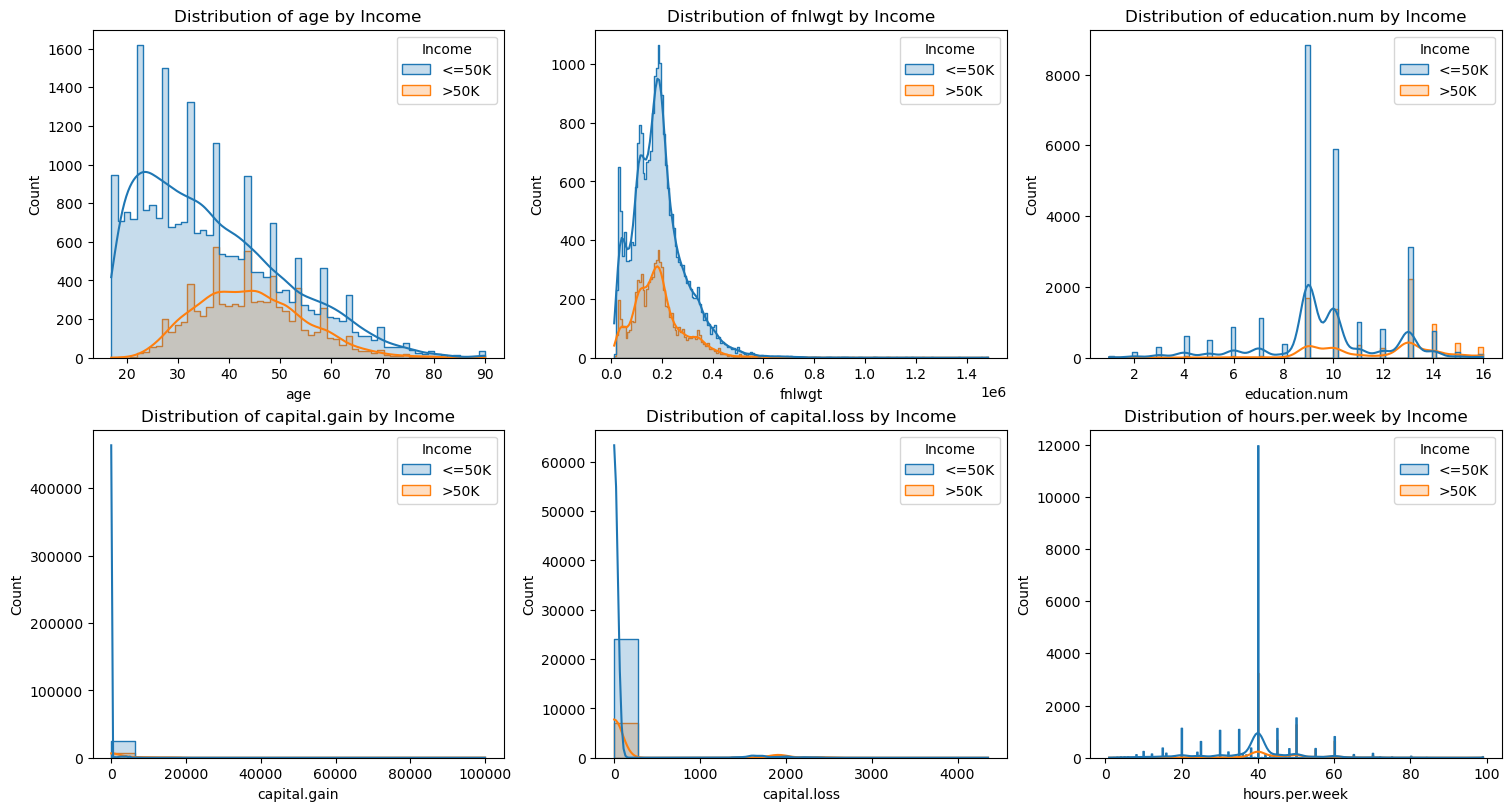

In [11]:
# data visualization
df= X.copy()
df['Income'] = y

numeric_features = selector(dtype_include=['int64', 'float64'])
categorical_features = selector(dtype_include=['object', 'category'])

cat_feats = categorical_features(df.drop(columns=['Income']))
num_feats = numeric_features(df.drop(columns=['Income']))

# --- Categorical in one figure ---
n_cat = len(cat_feats)
cols_cat = 3
rows_cat = math.ceil(n_cat / cols_cat)

fig_cat, axes_cat = plt.subplots(rows_cat, cols_cat, figsize=(cols_cat * 5, rows_cat * 4), constrained_layout=True)
axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_feats):
    ax = axes_cat[i]
    sns.countplot(data=df, x=col, hue='Income', ax=ax)
    ax.set_title(f'Distribution of {col} by Income')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].set_visible(False)

plt.show()

# --- Numeric in one figure ---
n_num = len(num_feats)
cols_num = 3
rows_num = math.ceil(n_num / cols_num)

fig_num, axes_num = plt.subplots(rows_num, cols_num, figsize=(cols_num * 5, rows_num * 4), constrained_layout=True)
axes_num = axes_num.flatten()

for i, col in enumerate(num_feats):
    ax = axes_num[i]
    sns.histplot(data=df, x=col, hue='Income', kde=True, element="step", ax=ax)
    ax.set_title(f'Distribution of {col} by Income')

for j in range(i + 1, len(axes_num)):
    axes_num[j].set_visible(False)

plt.show()



In [12]:
# split df into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(df['Income'].value_counts())


Income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [13]:
# dropping redundant features from X_train
def drop_high_corr_numeric(X, threshold=0.95):
    Xn = X.select_dtypes(include=np.number).copy()
    corr = Xn.corr().abs()
    upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
    upper_corr = corr.where(upper)
    to_drop = [col for col in upper_corr.columns if any(upper_corr[col] >= threshold)]

    # Return list of columns to keep (drop only numeric duplicates; keep categoricals)
    keep_cols = [c for c in X.columns if c not in to_drop]
    return keep_cols, to_drop

keep_cols, dropped_cols = drop_high_corr_numeric(X_train, threshold=0.95)
print("Dropped (numeric) due to high correlation:", dropped_cols)

# Filter training and test consistently
X_train = X_train[keep_cols].copy()
X_test = X_test[keep_cols].copy()


Dropped (numeric) due to high correlation: []



Training and evaluating model: Random Forest
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.89      0.89      4945
        >50K       0.65      0.65      0.65      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.77      0.77      6513
weighted avg       0.83      0.83      0.83      6513



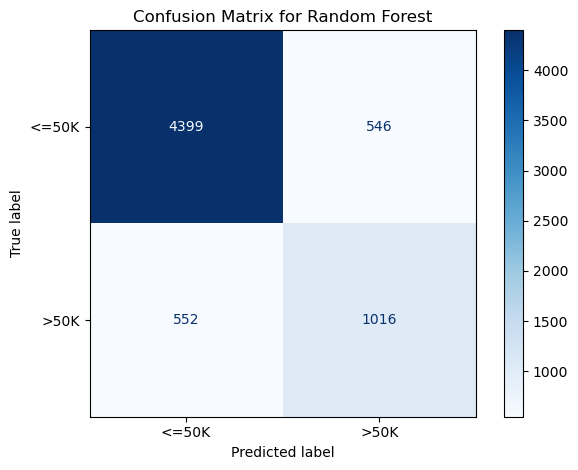


Training and evaluating model: Multinomial NB
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.79      0.96      0.87      4945
        >50K       0.61      0.21      0.31      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.58      0.59      6513
weighted avg       0.75      0.78      0.73      6513



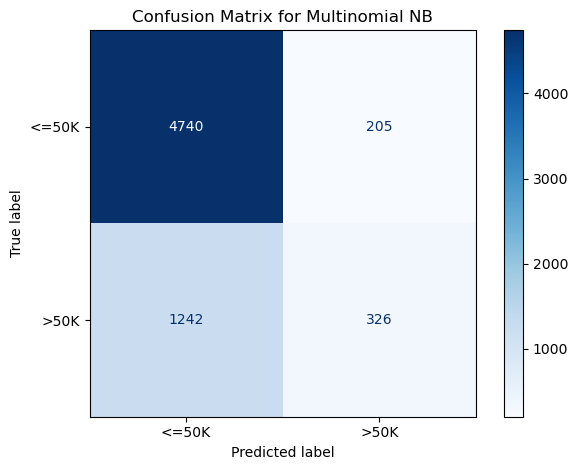


Training and evaluating model: GaussianNB
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.83      0.87      4945
        >50K       0.58      0.73      0.65      1568

    accuracy                           0.81      6513
   macro avg       0.74      0.78      0.76      6513
weighted avg       0.83      0.81      0.81      6513



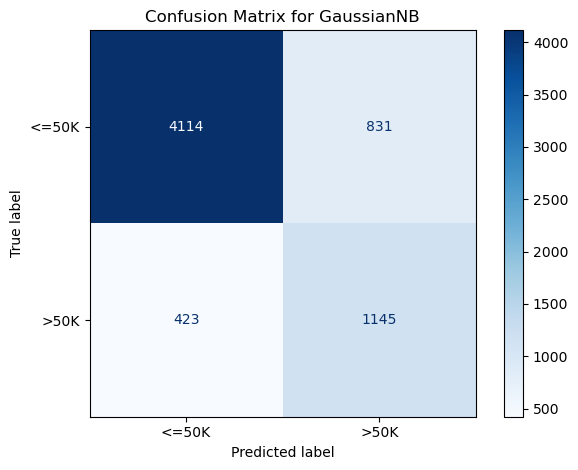

In [14]:
def training_class():
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        'Multinomial NB': MultinomialNB(),
        'GaussianNB': GaussianNB()   
    }

    # Preprocessing pipelines
    numeric_pipe = SkPipeline([
        ('imputer', SimpleImputer(strategy='median')),
       #('scaler', StandardScaler())
    ])
    categorical_pipe = SkPipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipe, numeric_features),
            ('cat', categorical_pipe, categorical_features),
        ]
    )

    for model_name, model in models.items():
        print(f"\nTraining and evaluating model: {model_name}")
                
        # Build pipeline per model
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('kbest', SelectKBest(score_func=f_classif, k=24)),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])

        # Fit & predict
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Metrics
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix plot)
        disp = ConfusionMatrixDisplay.from_estimator(
            pipe, X_test, y_test, cmap=plt.cm.Blues, normalize=None
        )
        disp.ax_.set_title(f'Confusion Matrix for {model_name}')
        plt.tight_layout()
        plt.show()
    
training_class()